<a href="https://colab.research.google.com/github/romitbarua/MultiModalDeepFake/blob/main/TestingNotebooks/PCAvsMFCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#### Articles Used to Generate Code
#https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184
#https://machinelearningmastery.com/face-recognition-using-principal-component-analysis/

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
import cv2
import dlib
from google.colab.patches import cv2_imshow
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import librosa
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [4]:
SYM_PATH = '/content/drive/MyDrive/DeepFakeDetection'
%cd $SYM_PATH
%pip install -e .

/content/drive/MyDrive/DeepFakeDetection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/DeepFakeDetection
  Running setup.py develop for DeepFake


In [5]:
from packages.DlibManager import DlibManager

predictor_path = '/content/drive/MyDrive/DeepFakeDetection/model/shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

In [6]:
#load the metadata
metadata = pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/meta_data.csv')
metadata = metadata[(metadata['method']=='real') | (metadata['method']=='wav2lip')]
metadata = metadata.rename(columns={'Unnamed: 9':'full_path'})
metadata['full_path'] = metadata['full_path'].str.replace('FakeAVCeleb/', '/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/')
metadata['full_path'] = metadata['full_path'] + '/' + metadata['path']
metadata = metadata[metadata['gender']=='men']

In [7]:
metadata.head()

,source,target1,target2,method,category,type,race,gender,path,full_path
0,id00076,-,-,real,A,RealVideo-RealAudio,African,men,00109.mp4,/content/drive/MyDrive/DeepFakeDetection/data/...
1,id00166,-,-,real,A,RealVideo-RealAudio,African,men,00010.mp4,/content/drive/MyDrive/DeepFakeDetection/data/...
2,id00173,-,-,real,A,RealVideo-RealAudio,African,men,00118.mp4,/content/drive/MyDrive/DeepFakeDetection/data/...
3,id00366,-,-,real,A,RealVideo-RealAudio,African,men,00118.mp4,/content/drive/MyDrive/DeepFakeDetection/data/...
4,id00391,-,-,real,A,RealVideo-RealAudio,African,men,00052.mp4,/content/drive/MyDrive/DeepFakeDetection/data/...


In [8]:
training_ids = np.random.choice(metadata.source.unique(), int(metadata.source.unique().shape[0]*0.8), replace=False)
testing_ids = np.array(metadata[~metadata['source'].isin(training_ids)]['source'].unique())

In [9]:
testing_ids.shape

(50,)

In [10]:
training_videos_details = []
failed_training_videos_dlib = []
for idx, training_id in enumerate(training_ids):
  print(f'Video #{idx+1} out of {len(training_ids)}')

  video_path = metadata[(metadata['source'] == training_id) & (metadata['method'] == 'real')]['full_path'].values[0]
  video = cv2.VideoCapture(video_path)
  audio_path = metadata[(metadata['source'] == training_id) & (metadata['method'] == 'real')]['full_path'].values[0].replace('.mp4', '.wav')
  audio, sample_rate = librosa.load(audio_path)

  try:
    dlib_video = DlibManager(predictor, detector, video)
    training_videos_details.append((training_id, dlib_video.lip_frames, audio, sample_rate))

  except:
    print(f'Failed to Upload: {training_id}')
    failed_training_videos_dlib

  video.release()


  

Video #1 out of 200
Video #2 out of 200
Video #3 out of 200
Video #4 out of 200
Video #5 out of 200
Video #6 out of 200
Video #7 out of 200
Video #8 out of 200
Video #9 out of 200
Video #10 out of 200
Video #11 out of 200
Failed to Upload: id03205
Video #12 out of 200
Video #13 out of 200
Video #14 out of 200
Video #15 out of 200
Video #16 out of 200
Failed to Upload: id00021
Video #17 out of 200
Video #18 out of 200
Video #19 out of 200
Video #20 out of 200
Video #21 out of 200
Video #22 out of 200
Video #23 out of 200
Video #24 out of 200
Video #25 out of 200
Failed to Upload: id04789
Video #26 out of 200
Video #27 out of 200
Video #28 out of 200
Video #29 out of 200
Video #30 out of 200
Video #31 out of 200
Video #32 out of 200
Video #33 out of 200
Video #34 out of 200
Video #35 out of 200
Failed to Upload: id04222
Video #36 out of 200
Video #37 out of 200
Video #38 out of 200
Video #39 out of 200
Video #40 out of 200
Video #41 out of 200
Video #42 out of 200
Video #43 out of 200
Vi

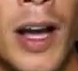

In [11]:
cv2_imshow(training_videos_details[50][1][30])

In [12]:
#video_path = '/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/RealVideo-RealAudio/African/men/id00076/00109.mp4'
#video = cv2.VideoCapture(video_path)

#predictor_path = '/content/drive/MyDrive/DeepFakeDetection/model/shape_predictor_68_face_landmarks.dat'
#detector = dlib.get_frontal_face_detector()
#predictor = dlib.shape_predictor(predictor_path)

In [13]:
#audio_path = '/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/RealVideo-RealAudio/African/men/id00076/00109.wav'
#audio, sample_rate = librosa.load(audio_path)

In [14]:
#vid1_dlib = DlibManager(predictor, detector, video)

In [15]:
def preprocess_lips(lip_frames, height=90, width=70):

  lip_frames_resized = []

  for frame in lip_frames:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(frame, (height, width))
    lip_frames_resized.append(resized_frame)

  lip_frames_resized = np.array(lip_frames_resized)
  lip_frames_resized = lip_frames_resized.reshape(lip_frames_resized.shape[0], lip_frames_resized.shape[1]*lip_frames_resized.shape[2])

  return lip_frames_resized


In [16]:
#resize all the lip frames to 70 x 90
#lip_frames_resized = []
#for frame in vid1_dlib.lip_frames:
#  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#  resized_frame = cv2.resize(frame, (90, 70))
#  lip_frames_resized.append(resized_frame)
#lip_frames_resized = np.array(lip_frames_resized)

In [54]:
def normalize(data, debug_mode = False):
  if debug_mode:
    print('NORMALIZE DATA')
    print('Data Shape: ', data.shape)
    print('Data Type: ', type(data.dtype))
    print('Mean Shape:', np.mean(data, axis=0).shape)
    print('Std Shape:', np.mean(data, axis=0).shape)
    print('------------------------------')
  return (data - np.mean(data, axis=0))/np.std(data, axis=0)

In [55]:
def generate_training_data(training_video_details, num_components, debug_mode = False):
  
  lips_data = None
  X  = None
  y = None

  for idx, training_video_data in enumerate(training_video_details):

    id, lip_frames, audio, sample_rate = training_video_data

    lip_frames_resized = preprocess_lips(lip_frames)
    #lip_frames_resized = lip_frames_resized.reshape(lip_frames_resized.shape[0], lip_frames_resized.shape[1]*lip_frames_resi zed.shape[2])
    
    row_count = lip_frames_resized.shape[0]

    mfcc_features = librosa.feature.mfcc(y=audio, hop_length=int(sample_rate*librosa.get_duration(audio)/row_count)).T[:row_count, :]
    mfcc_features = normalize(mfcc_features, debug_mode)

    if isinstance(lips_data, type(None)):
      lips_data = lip_frames_resized
      y = mfcc_features
    else:
      lips_data = np.vstack((lips_data, lip_frames_resized))
      y = np.vstack((y, mfcc_features))

  
  lips_data_mean = np.mean(lips_data, axis=0)
  lips_data_centered = lips_data - lips_data_mean

  pca = PCA()
  pca_lip_frames = pca.fit_transform(lips_data_centered)

  eigenfaces = pca.components_[:num_components]
  weights = np.dot(lips_data_centered, eigenfaces.T)

  X = weights

  return X, y, lips_data_mean, pca


In [74]:
X[35]

array([ 3.07950847e+03, -1.81121293e+02, -1.11819890e+02,  3.04523704e+02,
        3.46588864e+02,  2.53543780e+02,  5.17897940e+02, -3.15044330e+02,
       -5.49670352e+02, -3.29306424e+02, -1.86716890e+02, -2.95569258e+02,
        3.83083616e+02,  1.78333994e+02,  2.13972473e+02, -3.68131706e+02,
       -1.20504676e+02,  9.55726143e+01,  2.42545688e+02,  6.82191162e+01,
        1.73763742e+02, -3.71804163e+00,  1.44227613e+02,  3.32173873e+02,
       -2.75991883e+02, -4.10730516e+01,  4.56563450e+00, -1.59398626e+02,
       -2.11378798e+02,  7.32895511e+01,  9.53619725e+01, -4.28447965e+01,
       -6.25271501e+01,  2.50212603e+01,  7.67757388e+01, -9.66542919e+01,
        1.68565118e+02, -4.42215240e+01,  8.17132445e+01,  6.11051688e+01,
       -6.87794878e+01,  1.84017824e+01, -1.20831034e+00, -1.01131608e+02,
        7.92135435e+01,  5.15553854e+01, -4.89060532e+01,  5.22398049e+01,
        6.32371419e+01,  6.75250059e+01])

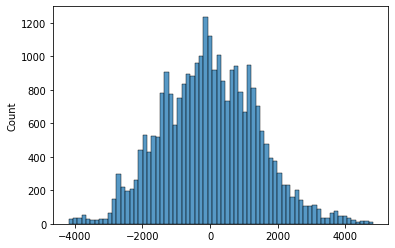

In [68]:
sns.histplot(X[:,1])

In [70]:
centered_vector=np.dot(X[35, :], pca.components_[:50])
recovered_image = (centered_vector+lips_data_mean).reshape((70, 90))

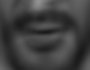

In [71]:
cv2_imshow(recovered_image)

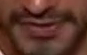

In [73]:
cv2_imshow(training_videos_details[0][1][35])

(28043, 50)

In [56]:
X, y, lips_data_mean, pca = generate_training_data(training_videos_details, 50)

(257, 20)
(20, 446)
NORMALIZE DATA
Data Shape:  (257, 20)
Data Type:  <class 'numpy.dtype[float32]'>
Mean Shape: (20,)
Std Shape: (20,)
------------------------------
(106, 20)
(20, 186)
NORMALIZE DATA
Data Shape:  (106, 20)
Data Type:  <class 'numpy.dtype[float32]'>
Mean Shape: (20,)
Std Shape: (20,)
------------------------------
(184, 20)
(20, 320)
NORMALIZE DATA
Data Shape:  (184, 20)
Data Type:  <class 'numpy.dtype[float32]'>
Mean Shape: (20,)
Std Shape: (20,)
------------------------------
(123, 20)
(20, 215)
NORMALIZE DATA
Data Shape:  (123, 20)
Data Type:  <class 'numpy.dtype[float32]'>
Mean Shape: (20,)
Std Shape: (20,)
------------------------------
(101, 20)
(20, 177)
NORMALIZE DATA
Data Shape:  (101, 20)
Data Type:  <class 'numpy.dtype[float32]'>
Mean Shape: (20,)
Std Shape: (20,)
------------------------------
(104, 20)
(20, 182)
NORMALIZE DATA
Data Shape:  (104, 20)
Data Type:  <class 'numpy.dtype[float32]'>
Mean Shape: (20,)
Std Shape: (20,)
-----------------------------

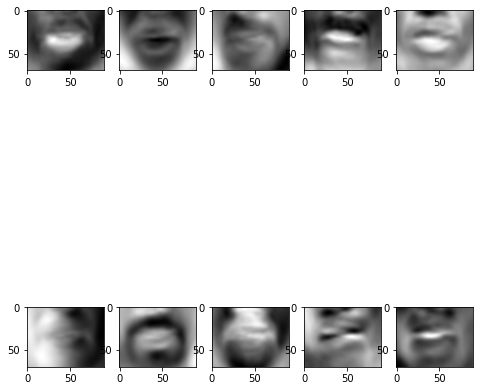

In [57]:
#show the eigenfaces
eigenfaces = pca.components_[:10]
 
# Show the first 16 eigenfaces
fig, axes = plt.subplots(2,5,figsize=(8,10))
idx = 0
for i in range(5):
  for j in range(2):
    axes[j][i].imshow(eigenfaces[idx].reshape((70, 90)), cmap="gray")
    idx += 1
plt.show()

In [58]:
def train_models(X, y, model_type='LinearRegression'):

  num_coef = y.shape[1]
  models = []
  for i in range(num_coef):
    assert X.shape[0] == y[:, i].shape[0], 'X and y must have the same number of rows'
    
    if model_type == 'LinearRegression':
      model = LinearRegression()
    elif model_type == 'RandomForest':
      model = RandomForestRegressor()
    model.fit(X, y[:, i])
    models.append(model)

  return models

In [59]:
models = train_models(X, y, 'LinearRegression')

In [60]:
testing_videos_details = []
failed_testing_videos_dlib = []
for idx, testing_id in enumerate(testing_ids):
  print(f'Video #{idx+1} out of {len(testing_ids)}')

  real_video_path = metadata[(metadata['source'] == testing_id) & (metadata['method'] == 'real')]['full_path'].values[0]
  fake_video_path = metadata[(metadata['source'] == testing_id) & (metadata['method']=='wav2lip')].sample(1)['full_path'].values[0]

  real_video = cv2.VideoCapture(real_video_path)
  fake_video = cv2.VideoCapture(fake_video_path)

  real_audio_path = real_video_path.replace('.mp4', '.wav')
  fake_audio_path = fake_video_path.replace('.mp4', '.wav')

  real_audio, real_sample_rate = librosa.load(real_audio_path)
  fake_audio, fake_sample_rate = librosa.load(fake_audio_path)

  try:
    real_dlib_video = DlibManager(predictor, detector, real_video)
    fake_dlib_video = DlibManager(predictor, detector, fake_video)
    testing_videos_details.append((testing_id, real_dlib_video.lip_frames, fake_dlib_video.lip_frames, real_audio, fake_audio, real_sample_rate, fake_sample_rate, real_video_path, fake_video_path))

  except:
    print(f'Failed to Upload: {testing_id}')
    failed_testing_videos_dlib.append((real_video_path, fake_video_path))

  real_video.release()
  fake_video.release()

Video #1 out of 50
Video #2 out of 50
Video #3 out of 50
Failed to Upload: id00478
Video #4 out of 50
Video #5 out of 50
Video #6 out of 50
Failed to Upload: id02005
Video #7 out of 50
Failed to Upload: id02040
Video #8 out of 50
Video #9 out of 50
Video #10 out of 50
Video #11 out of 50
Video #12 out of 50
Video #13 out of 50
Video #14 out of 50
Video #15 out of 50
Video #16 out of 50
Video #17 out of 50
Video #18 out of 50
Failed to Upload: id04073
Video #19 out of 50
Video #20 out of 50
Failed to Upload: id04221
Video #21 out of 50
Video #22 out of 50
Video #23 out of 50
Failed to Upload: id04691
Video #24 out of 50
Video #25 out of 50
Video #26 out of 50
Video #27 out of 50
Video #28 out of 50
Failed to Upload: id06535
Video #29 out of 50
Video #30 out of 50
Video #31 out of 50
Failed to Upload: id00185
Video #32 out of 50
Video #33 out of 50
Video #34 out of 50
Video #35 out of 50
Video #36 out of 50
Video #37 out of 50
Video #38 out of 50
Video #39 out of 50
Video #40 out of 50
V

In [61]:
def eval_test_data(testing_video_details, pca, lips_data_mean, models, num_components=10, debug_mode=False):

  real_video_error = []
  fake_video_error = []

  for idx, testing_video in enumerate(testing_video_details):

    real_mfcc_errors = []
    fake_mfcc_errors = []

    testing_id, real_lip_frames, fake_lip_frames, real_audio, fake_audio, real_sample_rate, fake_sample_rate, real_video_path, fake_video_path = testing_video

    if debug_mode:
      print()
      print('RUNNING TESTING FOR: ', testing_id)
      print('Real Video Path: ', real_video_path)
      print('Fake Video Path: ', fake_video_path)
      print('--------------------------------------------')
      print('--------------------------------------------')

    if debug_mode:
      print('Num of Items in Testing Video: ', len(testing_video))
      #print('Testing Video Items: ', testing_video)

    real_lip_frames_resized = preprocess_lips(real_lip_frames)
    fake_lip_frames_resized = preprocess_lips(fake_lip_frames)

    if debug_mode:
      print('LIP FRAME SHAPES')
      print('Real Lip Frames: ', real_lip_frames_resized.shape)
      print('Fake Lip Frames: ', fake_lip_frames_resized.shape)
      print('--------------------------------------------')

    real_row_count = real_lip_frames_resized.shape[0]
    fake_row_count = fake_lip_frames_resized.shape[0]

    real_duration = librosa.get_duration(real_audio)
    fake_duration = librosa.get_duration(fake_audio)

    real_mfcc_features = librosa.feature.mfcc(y=real_audio, hop_length=int(real_sample_rate*real_duration/real_row_count)).T[:real_row_count, :]
    real_mfcc_features = normalize(real_mfcc_features)
    fake_mfcc_features = librosa.feature.mfcc(y=fake_audio, hop_length=int(fake_sample_rate*fake_duration/fake_row_count)).T[:fake_row_count, :]
    fake_mfcc_features = normalize(fake_mfcc_features)

    if debug_mode:
      print('ORIGINAL MFCC FRAME SHAPES')
      print('Real MFCC Frames: ', real_mfcc_features.shape)
      print('Real Sample Rate:', real_sample_rate)
      print('Real Duration: ', real_duration)
      print('Real Frame Count: ', real_row_count)
      print('Fake MFCC Frames: ', fake_mfcc_features.shape)
      print('Fake Sample Rate:', fake_sample_rate)
      print('Fake Duration: ', fake_duration)
      print('Fake Frame Count: ', fake_row_count)
      print('--------------------------------------------')


    real_lips_centered = real_lip_frames_resized - lips_data_mean
    fake_lips_centered = fake_lip_frames_resized - lips_data_mean

    real_pca_lip_frames = pca.transform(real_lips_centered)
    fake_pca_lip_frames = pca.transform(fake_lips_centered)


    eigenfaces = pca.components_[:num_components]
    real_weights = np.dot(real_lips_centered, eigenfaces.T)
    fake_weights = np.dot(fake_lips_centered, eigenfaces.T)

    X_real = real_weights
    X_fake = fake_weights
    y_real = real_mfcc_features
    y_fake = fake_mfcc_features


    if debug_mode:
      print('TRAINING DATA SHAPES')
      print('X Real Shape:', X_real.shape)
      print('X Fake Shape:', X_fake.shape)
      print('y Real Shape:', y_real.shape)
      print('y Fake Shape:', y_fake.shape)
      print('--------------------------------------------')

    for idx, model in enumerate(models):
      y_real_pred = model.predict(X_real)
      y_fake_pred = model.predict(X_fake)

      real_err = mean_squared_error(y_true=y_real[:, idx], y_pred=y_real_pred)
      fake_err = mean_squared_error(y_true=y_fake[:, idx], y_pred=y_fake_pred)

      real_mfcc_errors.append(real_err)
      fake_mfcc_errors.append(fake_err)

    real_video_error.append(np.mean(real_mfcc_errors))
    fake_video_error.append(np.mean(fake_mfcc_errors))


  return real_video_error, fake_video_error


In [62]:
real_video_error, fake_video_error = eval_test_data(testing_videos_details, pca, lips_data_mean, models, 50, False)

NORMALIZE DATA
Data Shape:  (300, 20)
Data Type:  <class 'numpy.dtype[float32]'>
Mean Shape: (20,)
Std Shape: (20,)
------------------------------
NORMALIZE DATA
Data Shape:  (283, 20)
Data Type:  <class 'numpy.dtype[float32]'>
Mean Shape: (20,)
Std Shape: (20,)
------------------------------
NORMALIZE DATA
Data Shape:  (240, 20)
Data Type:  <class 'numpy.dtype[float32]'>
Mean Shape: (20,)
Std Shape: (20,)
------------------------------
NORMALIZE DATA
Data Shape:  (137, 20)
Data Type:  <class 'numpy.dtype[float32]'>
Mean Shape: (20,)
Std Shape: (20,)
------------------------------
NORMALIZE DATA
Data Shape:  (145, 20)
Data Type:  <class 'numpy.dtype[float32]'>
Mean Shape: (20,)
Std Shape: (20,)
------------------------------
NORMALIZE DATA
Data Shape:  (122, 20)
Data Type:  <class 'numpy.dtype[float32]'>
Mean Shape: (20,)
Std Shape: (20,)
------------------------------
NORMALIZE DATA
Data Shape:  (108, 20)
Data Type:  <class 'numpy.dtype[float32]'>
Mean Shape: (20,)
Std Shape: (20,)
--

In [26]:
len(fake_video_error)

40

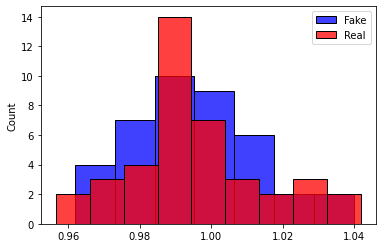

In [63]:
sns.histplot(fake_video_error, label='Fake', color='blue')
sns.histplot(real_video_error, label='Real', color='red')
plt.legend()
plt.show()

In [28]:
#reshape_lip_frames = lip_frames_resized.reshape(lip_frames_resized.shape[0], lip_frames_resized.shape[1]*lip_frames_resized.shape[2])


In [29]:
#scalar = StandardScaler()
#centered_lip_frames = scalar.fit_transform(reshape_lip_frames)

#avg_lip_frames = np.mean(reshape_lip_frames, axis=0)
#centered_lip_frames = reshape_lip_frames - avg_lip_frames

In [30]:
#pca = PCA()
#pca_lip_frames = pca.fit_transform(centered_lip_frames)

In [31]:
#random_samples = np.random.choice(np.arange(0, reshape_lip_frames.shape[0]), 5)
#random_samples

In [32]:
#def reconstruction(pca, num_components, centered_data, mean, image_idx, height=70, width=90):
#  eigenfaces = pca.components_[:num_components]
#  samples, features = centered_data.shape
#  weights = np.dot(centered_data, eigenfaces.T)
#  recovered_image = (np.dot(weights[image_idx,:], eigenfaces)+mean).reshape(height, width)
#  return recovered_image



In [33]:
#fig, axes = plt.subplots(5,2,sharex=True,sharey=True,figsize=(8,10))
#fig.suptitle('Eigenface Count: 1', fontsize=16)
#for idx, sample in enumerate(random_samples):
#  orig = vid1_dlib.lip_frames[sample]
#  reconstructed = reconstruction(pca, 1, centered_lip_frames, avg_lip_frames, sample)
#  axes[idx, 0].imshow(orig)
#  axes[idx, 1].imshow(reconstructed, cmap="gray")
#plt.show()
  

In [34]:
'''
fig, axes = plt.subplots(5,2,sharex=True,sharey=True,figsize=(8,10))
fig.suptitle('Eigenface Count: 10', fontsize=16)
for idx, sample in enumerate(random_samples):
  orig = vid1_dlib.lip_frames[sample]
  reconstructed = reconstruction(pca, 10, centered_lip_frames, avg_lip_frames, sample)
  axes[idx, 0].imshow(orig)
  axes[idx, 1].imshow(reconstructed, cmap="gray")
plt.show()
'''  

'\nfig, axes = plt.subplots(5,2,sharex=True,sharey=True,figsize=(8,10))\nfig.suptitle(\'Eigenface Count: 10\', fontsize=16)\nfor idx, sample in enumerate(random_samples):\n  orig = vid1_dlib.lip_frames[sample]\n  reconstructed = reconstruction(pca, 10, centered_lip_frames, avg_lip_frames, sample)\n  axes[idx, 0].imshow(orig)\n  axes[idx, 1].imshow(reconstructed, cmap="gray")\nplt.show()\n'

In [35]:
'''
mfcc_features = librosa.feature.mfcc(y=audio, hop_length=int(sample_rate*librosa.get_duration(audio)/251)).T[:251, :]
'''

'\nmfcc_features = librosa.feature.mfcc(y=audio, hop_length=int(sample_rate*librosa.get_duration(audio)/251)).T[:251, :]\n'

In [36]:
'''
coef_one_mfcc = mfcc_features[:, 0].reshape(251, 1)
'''

'\ncoef_one_mfcc = mfcc_features[:, 0].reshape(251, 1)\n'

In [37]:
#weights.shape

In [38]:
#coef_one_mfcc.shape


In [39]:
'''
eigenfaces = pca.components_[:10]
samples, features = centered_lip_frames.shape
weights = np.dot(centered_lip_frames, eigenfaces.T)

train_test_data = np.hstack((weights, coef_one_mfcc.reshape(251, 1)))
'''

'\neigenfaces = pca.components_[:10]\nsamples, features = centered_lip_frames.shape\nweights = np.dot(centered_lip_frames, eigenfaces.T)\n\ntrain_test_data = np.hstack((weights, coef_one_mfcc.reshape(251, 1)))\n'

In [40]:
#X_train, X_test, y_train, y_test = train_test_split(weights, coef_one_mfcc, test_size=0.15, random_state=12)

In [41]:
'''
model = LinearRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)
err = np.sqrt(mean_squared_error(y_true=y_test, y_pred=pred))/len(pred)
print(err)
'''

'\nmodel = LinearRegression()\nmodel.fit(X_train, y_train)\n\npred = model.predict(X_test)\nerr = np.sqrt(mean_squared_error(y_true=y_test, y_pred=pred))/len(pred)\nprint(err)\n'

In [42]:
#def train(X, y)

In [43]:
'''
def evaluate(X_test, y_):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)

  model = LinearRegression()
  model.fit(X_train, y_train)

  pred = model.predict(X_test)
  err = np.sqrt(mean_squared_error(y_true=y_test, y_pred=pred))/len(pred)

  return pred, err
'''


'\ndef evaluate(X_test, y_):\n  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)\n\n  model = LinearRegression()\n  model.fit(X_train, y_train)\n\n  pred = model.predict(X_test)\n  err = np.sqrt(mean_squared_error(y_true=y_test, y_pred=pred))/len(pred)\n\n  return pred, err\n'